# Spike Inactivation

This project explores how to measure spike inactivation and compares inactivation in NAc MSNs of a control vs. drug group

## Set-Up the Environment

* This code is not intended to be reviewed in this document. 
* Code in jupyter notebooks is not reusable or testable.
* Mature functions should be moved into modules after the notebook is finished.

In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np

def getStepTrace(abf, sweepIndex, stepEpochIndex = 2, skipMsec = 50):
    """
    Return the isolated voltage trace during the depolarizing step.
    The depolarizing step is defined by the epoch number, and the first
    bit of time is trimmed to prevent analysis of the rising phase.
    """
    abf.setSweep(sweepIndex)
    stepIndex1 = abf.sweepEpochs.p1s[stepEpochIndex]
    stepIndex2 = abf.sweepEpochs.p2s[stepEpochIndex]
    skipPoints = skipMsec * abf.dataPointsPerMs
    trace = abf.sweepY[stepIndex1+skipPoints:stepIndex2]
    return trace

def plotTrace(trace, newFigure = True, showFigure = True, title = None):
    """
    Plot an isolated trace but do not show the figure
    """
    if (newFigure):    
        plt.figure(figsize=(12, 4))
        
    times = np.arange(len(trace)) / abf.dataRate
    plt.plot(times, trace, lw=.5)
    plt.ylabel("Potential (mV)")
    plt.xlabel("Time (seconds)")
    plt.title(title)
    
    if (showFigure):
        plt.show()
        
def getApIndexes(trace, sampleRate, threshold):
    """
    Detect action potentials using a first derivative threshold (mV/ms).
    Returns a list of indexes where each AP first crossed this threshold.
    """
    
    dVdt = np.diff(trace) * sampleRate / 1000 # mV/ms
    
    indexesAboveThreshold = np.where(dVdt >= threshold)[0]
    if (len(indexesAboveThreshold)<5):
        return [] # no points above threshold

    apIndexes = [indexesAboveThreshold[0]]
    for i in range(1, len(indexesAboveThreshold)):
        pointsSinceLastCrossing = indexesAboveThreshold[i] - apIndexes[-1]
        if (pointsSinceLastCrossing > 100):
            apIndexes.append(indexesAboveThreshold[i])
        
    return apIndexes

## Defining Spike Inactivation

We define _spike inactivation_ as the period of time where a continuously-firing neuron stops firing for reasons other than a depolarization-induced inability to relieve the inactivation gate of voltage-gated sodium channels. Spike inactivation in NAc neurons can be induced by mAChR as reported in [_Muscarinic Enhancement of Persistent Sodium Current Synchronizes Striatal
Medium Spiny Neurons_ (Carrillo-Reid et al., 2009)](https://journals.physiology.org/doi/pdf/10.1152/jn.00134.2009)

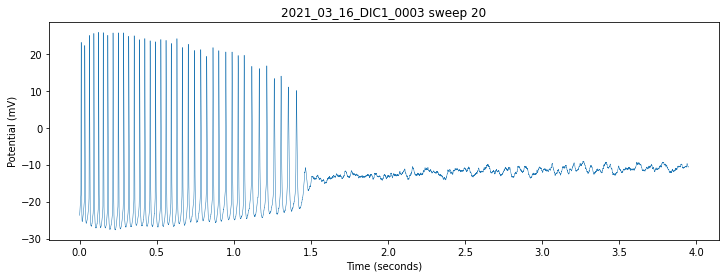

In [2]:
abfFilePath = R"X:\Data\C57\Sigma-1R\ephys\NAc-core-SA4503-incubation\2021_03_16_DIC1_0003.abf"
abf = pyabf.ABF(abfFilePath)
trace = getStepTrace(abf, 20)
plotTrace(trace, title=f"{abf.abfID} sweep {abf.sweepNumber}")

## Detect Action Potentials (APs)

APs are identified using the a first derivative threshold

In [3]:
apThreshold = 5 # mv/ms
apIndexes = getApIndexes(trace, abf.dataRate, apThreshold)
print(f"Sweep has {len(apIndexes)} APs")

Sweep has 38 APs


AP detection can be demonstrated visually:

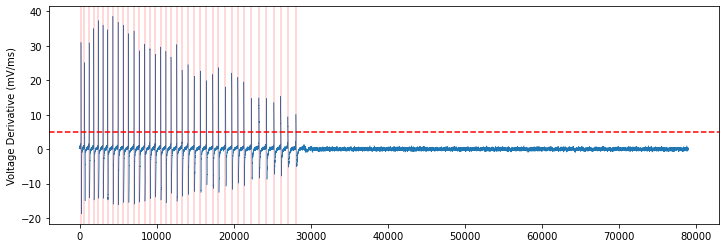

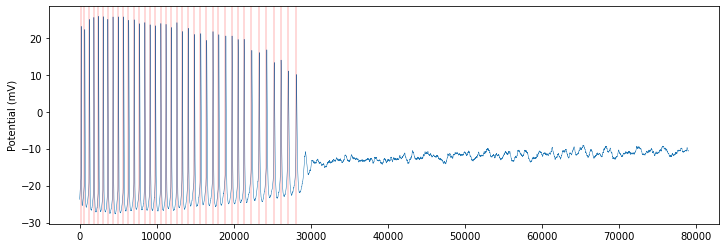

In [4]:
dVdt = np.diff(trace) * abf.dataRate / 1000 # mV/ms
    
plt.figure(figsize=(12, 4))
plt.plot(dVdt, lw=.5)
plt.ylabel("Voltage Derivative (mV/ms)")
plt.axhline(apThreshold, color='r', ls='--')
for apIndex in apIndexes:
    plt.axvline(apIndex, alpha=.2, color='r')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(trace, lw=.5)
plt.ylabel("Potential (mV)")
for apIndex in apIndexes:
    plt.axvline(apIndex, alpha=.2, color='r')
plt.show()

# Measure Inactivation Time

Inactivation time is the period between the last action potential and the end of the trace.

Inactivation times less than 100ms are ignored.

inactivation time: 2.5471000000000004 sec


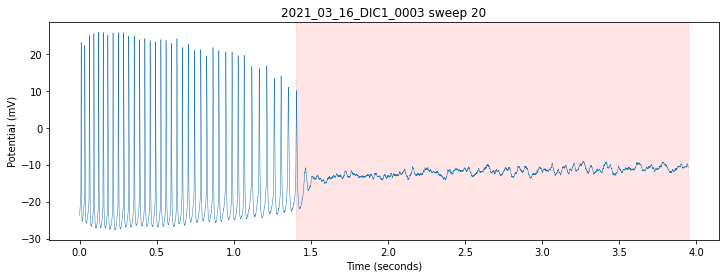

In [5]:
minimumInactivationTime = 0.1 # seconds

lastApIndex = apIndexes[-1]
lastApTime = lastApIndex / abf.dataRate
traceEndTime = len(trace) / abf.dataRate
inactivationTime = traceEndTime - lastApTime
if (inactivationTime < minimumInactivationTime):
    inactivationTime = 0
    
print(f"inactivation time: {inactivationTime} sec")

plotTrace(trace, showFigure=False, title=f"{abf.abfID} sweep {abf.sweepNumber}")
plt.axvspan(lastApTime, traceEndTime, alpha=.1, color='r')
plt.show()

## Iterate for Every Sweep

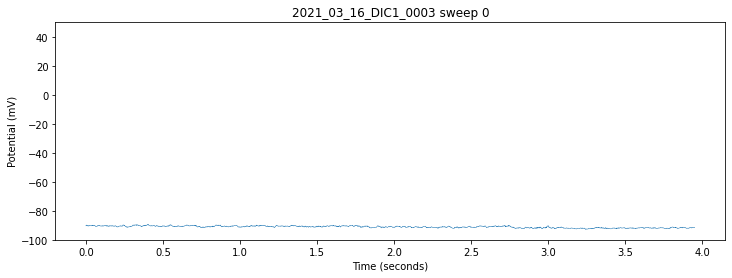

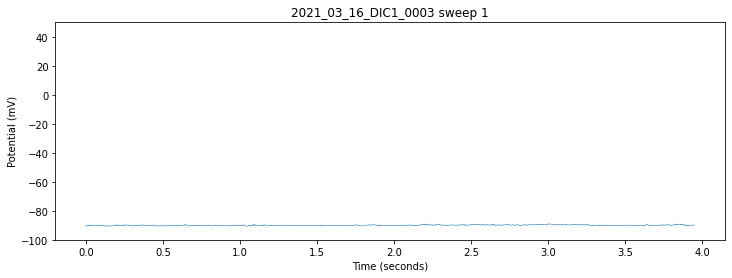

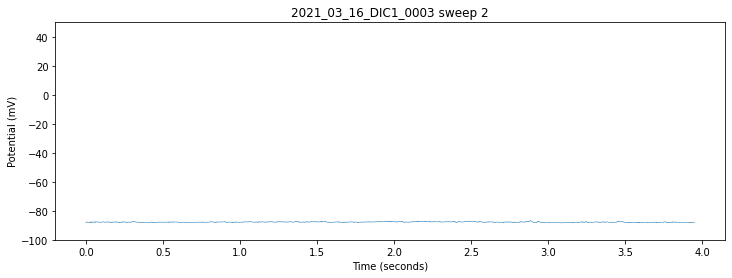

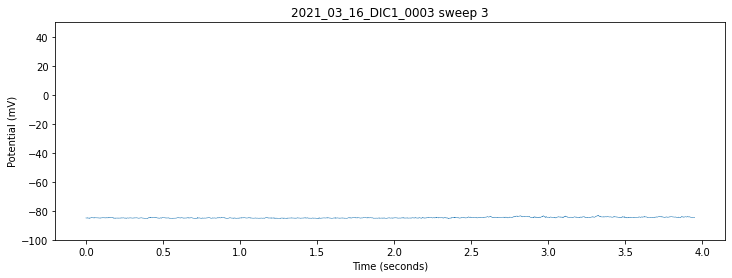

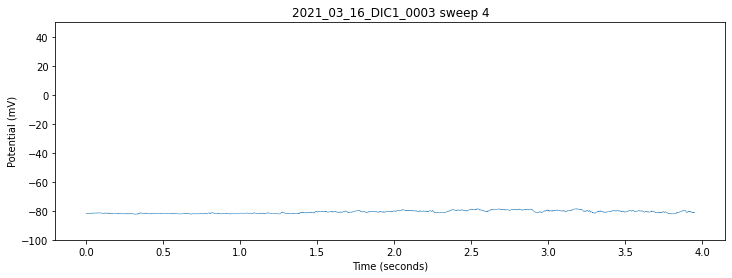

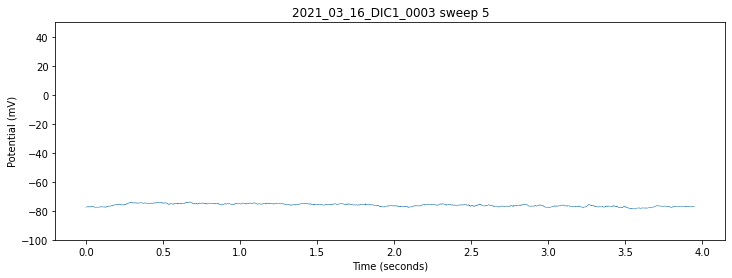

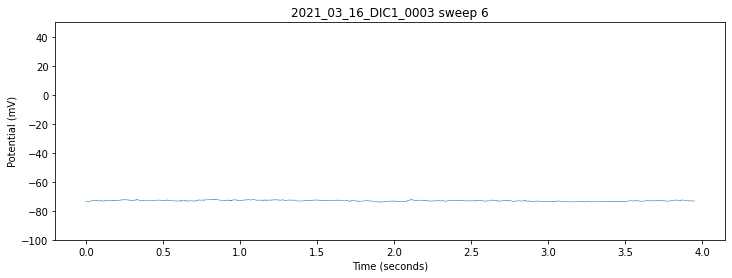

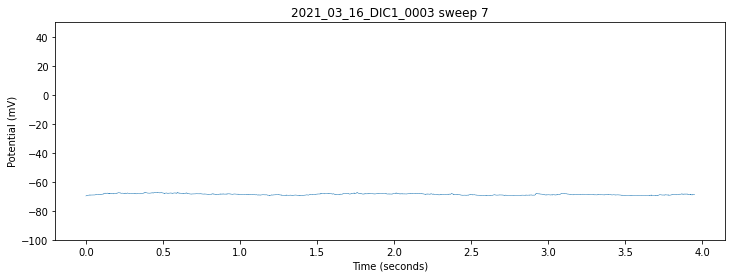

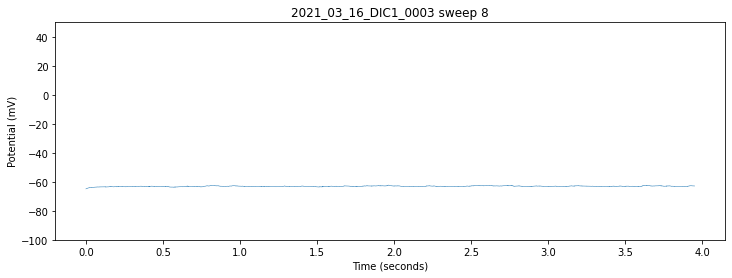

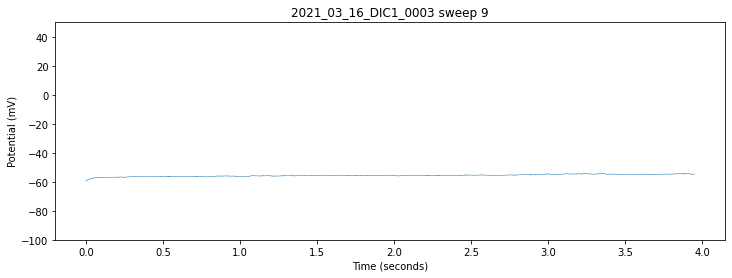

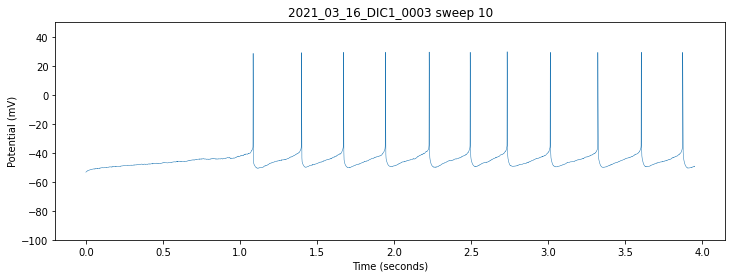

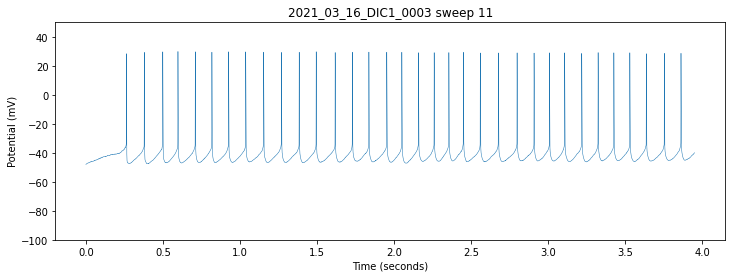

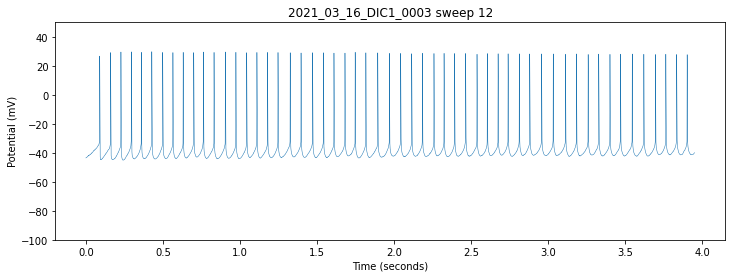

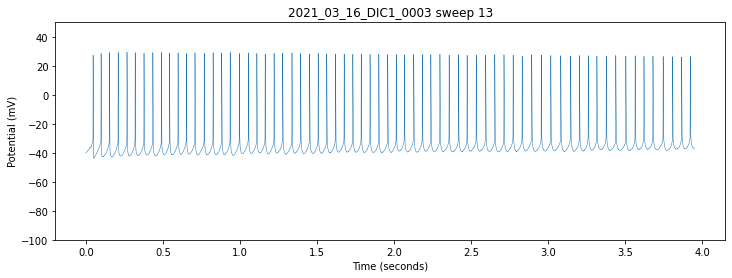

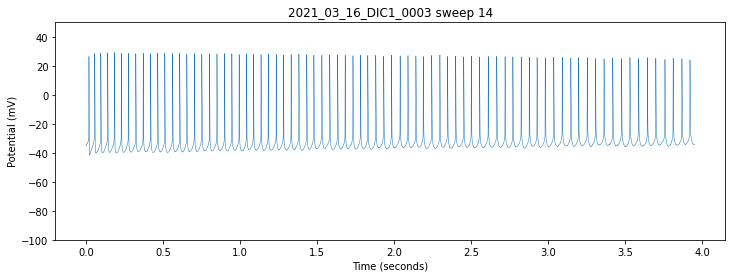

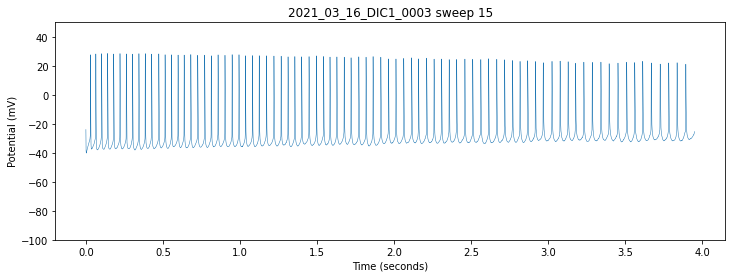

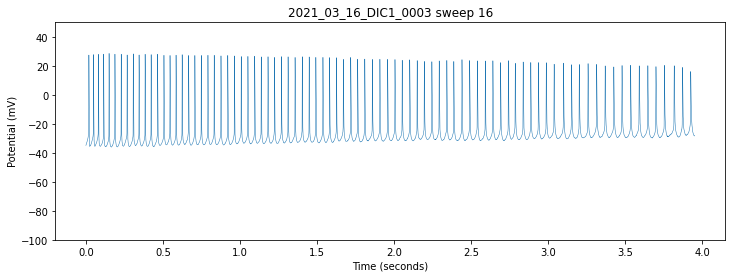

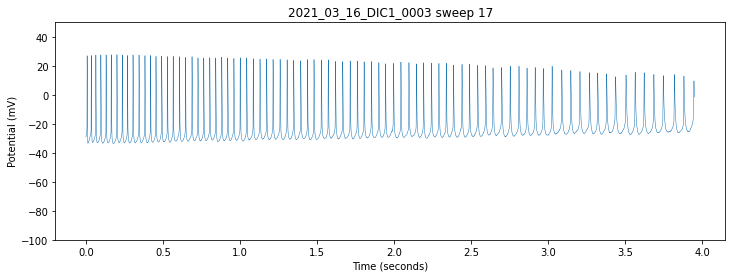

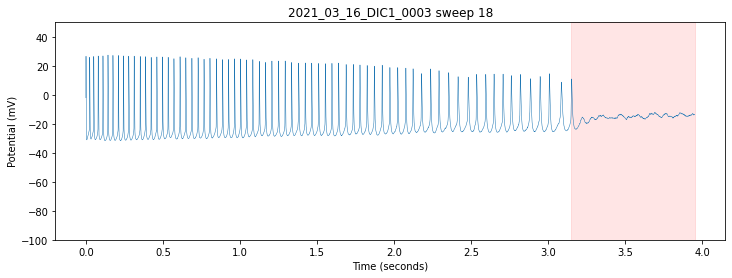

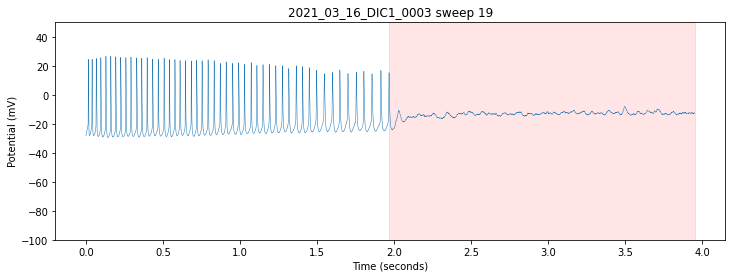

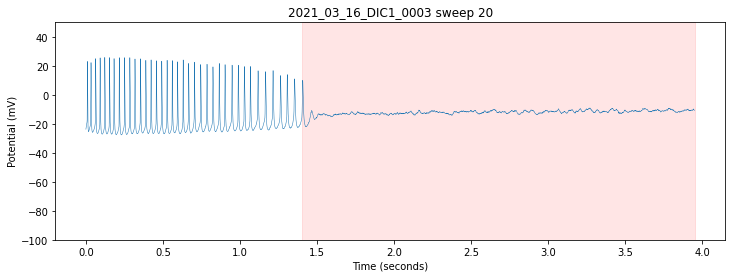

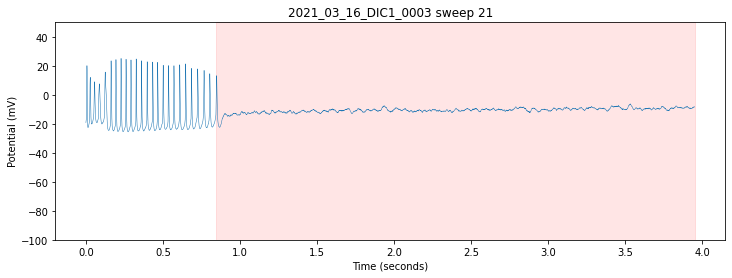

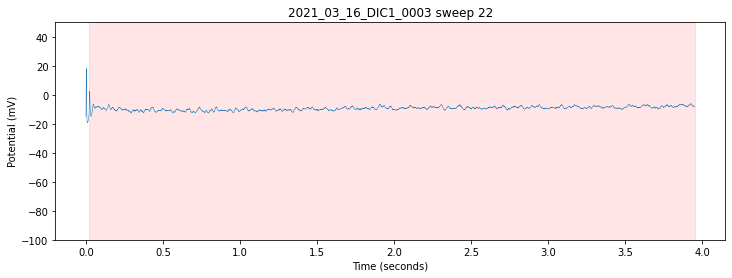

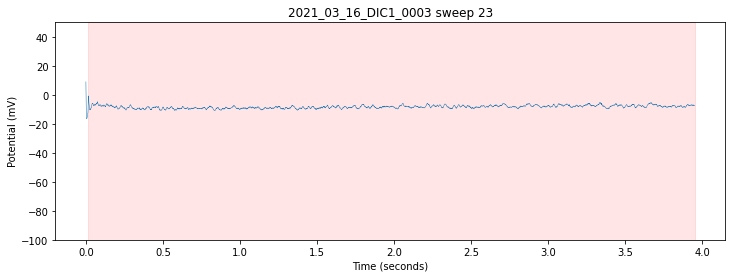

In [6]:
apThreshold = 5 # mv/ms

# difficult ABF with slow APs in the middle of silence
#abf = pyabf.ABF("X:/Data/Sigma1-Cre/ephys/C57/2021_03_22_DIC1_0054.abf")

inactivationTimes = [0] * abf.sweepCount
for sweepIndex in range(abf.sweepCount):  
    trace = getStepTrace(abf, sweepIndex)
    apIndexes = getApIndexes(trace, abf.dataRate, apThreshold)
    
    if len(apIndexes) == 0:
        plotTrace(trace, showFigure = False, title=f"{abf.abfID} sweep {abf.sweepNumber}")
        plt.axis([None, None, -100, 50])
        plt.show()
        continue

    lastApIndex = apIndexes[-1]
    lastApTime = lastApIndex / abf.dataRate
    traceEndTime = len(trace) / abf.dataRate
    inactivationTime = traceEndTime - lastApTime
    
    plotTrace(trace, showFigure = False, title=f"{abf.abfID} sweep {abf.sweepNumber}")
    if inactivationTime >= minimumInactivationTime: 
        inactivationTimes[sweepIndex] = inactivationTime
        plt.axvspan(lastApTime, traceEndTime, alpha=.1, color='r')
        
    plt.axis([None, None, -100, 50])
    plt.show()

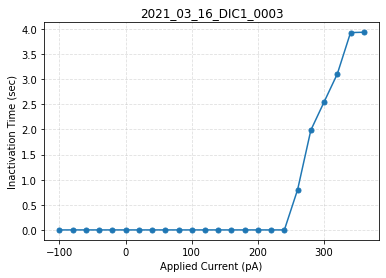

In [7]:
currents = np.arange(abf.sweepCount) * 20 - 100
plt.plot(currents, inactivationTimes, '.-', ms=10)
plt.ylabel("Inactivation Time (sec)")
plt.xlabel("Applied Current (pA)")
plt.title(abf.abfID)
plt.grid(alpha=.4, ls='--')
plt.show()